Machine Learning Model to predict Activity Coefficient

In [1]:
import polars as pl

file1 = r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma.csv"
file2 = r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma_Extra.csv"


with open(file1, "r") as f:
    header1 = f.readline().strip().split(",")
print(header1)

with open(file2, "r") as f:
    header2 = f.readline().strip().split(",")
print(header2)

# Read CSVs (handle encoding issues for file2 if needed)
df1 = pl.read_csv(file1)
df2 = pl.read_csv(file2, encoding="utf8-lossy", ignore_errors=True)

# Row counts before merge
print(f"📄 Rows in file1 before merge: {df1.shape[0]}")
print(f"📄 Rows in file2: {df2.shape[0]}")

# Merge
merged_df = pl.concat([df1, df2], how="vertical_relaxed")

# Row count after merge
print(f"📄 Rows in file1 after merge: {merged_df.shape[0]}")

# Save
merged_df.write_csv(file1)
print("✅ Merged and saved to:", file1)

['SL', 'Cation1', 'Anion1', 'Cation2', 'Anion2', 'x1', 'gam1', 'gam2', 'HE', 'GE', 'sigma1_0', 'sigma1_1', 'sigma1_2', 'sigma1_3', 'sigma1_4', 'sigma1_5', 'sigma1_6', 'sigma1_7', 'sigma1_8', 'sigma1_9', 'sigma1_10', 'sigma1_11', 'sigma1_12', 'sigma1_13', 'sigma1_14', 'sigma1_15', 'sigma1_16', 'sigma1_17', 'sigma1_18', 'sigma1_19', 'sigma1_20', 'sigma1_21', 'sigma1_22', 'sigma1_23', 'sigma1_24', 'sigma1_25', 'sigma1_26', 'sigma1_27', 'sigma1_28', 'sigma1_29', 'sigma1_30', 'sigma1_31', 'sigma1_32', 'sigma1_33', 'sigma1_34', 'sigma1_35', 'sigma1_36', 'sigma1_37', 'sigma1_38', 'sigma1_39', 'sigma1_40', 'sigma1_41', 'sigma1_42', 'sigma1_43', 'sigma1_44', 'sigma1_45', 'sigma1_46', 'sigma1_47', 'sigma1_48', 'sigma1_49', 'sigma2_0', 'sigma2_1', 'sigma2_2', 'sigma2_3', 'sigma2_4', 'sigma2_5', 'sigma2_6', 'sigma2_7', 'sigma2_8', 'sigma2_9', 'sigma2_10', 'sigma2_11', 'sigma2_12', 'sigma2_13', 'sigma2_14', 'sigma2_15', 'sigma2_16', 'sigma2_17', 'sigma2_18', 'sigma2_19', 'sigma2_20', 'sigma2_21', '

In [2]:

import csv
import polars as pl


in_path  = r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma.csv"
out_path = r"H:\Nahid\BinaryILsgammadata\Clean_BinaryILsGamma.csv"

def detect_sep_and_cols(path, sample_bytes=65536):
    with open(path, "r", encoding="utf-8", errors="ignore", newline="") as f:
        sample = f.read(sample_bytes)
    try:
        sep = csv.Sniffer().sniff(sample, delimiters=[",",";","\t","|"]).delimiter
    except Exception:
        counts = {d: sample.count(d) for d in [",",";","\t","|"]}
        sep = max(counts, key=counts.get)
    first_line = sample.splitlines()[0]
    cols = next(csv.reader([first_line], delimiter=sep))
    return [c.strip() for c in cols], sep

cols, sep = detect_sep_and_cols(in_path)
schema = {c: pl.Utf8 for c in cols}

# Build base lazy frame: read EVERYTHING as text to avoid parse issues
try:
    base = pl.scan_csv(
        in_path,
        separator=sep,
        null_values=["", "NA", "NaN", "nan", "null", "NULL", "None"],
        schema_overrides=schema,   # some Polars versions
        infer_schema_length=0,
    )
except TypeError:
    base = pl.scan_csv(
        in_path,
        separator=sep,
        null_values=["", "NA", "NaN", "nan", "null", "NULL", "None"],
        dtypes=schema,             # older Polars versions
        infer_schema_length=0,
    )

num_cols = cols[5:]  # columns 6..end treated as numeric

# Clean & cast numeric region
cleaned = base.with_columns([
    pl.col(c).str.replace(",", ".").cast(pl.Float32, strict=False).alias(c)
    for c in num_cols
])
cleaned = cleaned.drop_nulls()
cleaned = cleaned.filter(pl.all_horizontal([pl.col(c).is_finite() for c in num_cols]))

# Counts (each count scans once; still streaming-safe)
orig_n  = base.select(pl.len().alias("n")).collect()["n"][0]
clean_n = cleaned.select(pl.len().alias("n")).collect()["n"][0]
drop_n  = orig_n - clean_n

# Write cleaned file
cleaned.sink_csv(out_path, include_header=True)

print(f"📊 Original rows: {orig_n:,}")
print(f"🗑️  Dropped rows:  {drop_n:,}")
print(f"✅ Kept rows:      {clean_n:,}")
print("💾 Saved to:", out_path)

📊 Original rows: 4,929,321
🗑️  Dropped rows:  32,091
✅ Kept rows:      4,897,230
💾 Saved to: H:\Nahid\BinaryILsgammadata\Clean_BinaryILsGamma.csv


In [1]:
import csv
import polars as pl

in_path  = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_BinaryILsGamma_miscible_305.csv"
out_path = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_Clean_305.csv"

def detect_sep_and_cols(path, sample_bytes=65536):
    with open(path, "r", encoding="utf-8", errors="ignore", newline="") as f:
        sample = f.read(sample_bytes)
    try:
        sep = csv.Sniffer().sniff(sample, delimiters=[",",";","\t","|"]).delimiter
    except Exception:
        counts = {d: sample.count(d) for d in [",",";","\t","|"]}
        sep = max(counts, key=counts.get)
    first_line = sample.splitlines()[0]
    cols = next(csv.reader([first_line], delimiter=sep))
    return [c.strip() for c in cols], sep

cols, sep = detect_sep_and_cols(in_path)
schema = {c: pl.Utf8 for c in cols}

# Build base lazy frame: read EVERYTHING as text to avoid parse issues
try:
    base = pl.scan_csv(
        in_path,
        separator=sep,
        null_values=["", "NA", "NaN", "nan", "null", "NULL", "None"],
        schema_overrides=schema,   # some Polars versions
        infer_schema_length=0,
    )
except TypeError:
    base = pl.scan_csv(
        in_path,
        separator=sep,
        null_values=["", "NA", "NaN", "nan", "null", "NULL", "None"],
        dtypes=schema,             # older Polars versions
        infer_schema_length=0,
    )

num_cols = cols[5:]  # columns 6..end treated as numeric

# Clean & cast numeric region
cleaned = base.with_columns([
    pl.col(c).str.replace(",", ".").cast(pl.Float32, strict=False).alias(c)
    for c in num_cols
])
cleaned = cleaned.drop_nulls()
cleaned = cleaned.filter(pl.all_horizontal([pl.col(c).is_finite() for c in num_cols]))

# Counts (each count scans once; still streaming-safe)
orig_n  = base.select(pl.len().alias("n")).collect()["n"][0]
clean_n = cleaned.select(pl.len().alias("n")).collect()["n"][0]
drop_n  = orig_n - clean_n

# Write cleaned file
cleaned.sink_csv(out_path, include_header=True)

print(f"📊 Original rows: {orig_n:,}")
print(f"🗑️  Dropped rows:  {drop_n:,}")
print(f"✅ Kept rows:      {clean_n:,}")
print("💾 Saved to:", out_path)


📊 Original rows: 1,911
🗑️  Dropped rows:  26
✅ Kept rows:      1,885
💾 Saved to: H:\Nahid\BinaryILsgammadata\EXPData\EXP_Clean_305.csv


In [6]:
# === Load CSVs ===
import polars as pl

# === File paths ===
master_path = r"H:\Nahid\BinaryILsgammadata\Clean_BinaryILsGamma.csv"
second_path = r"H:\Nahid\BinaryILsgammadata\expdata.csv"

# === Keys to match ===
keys = ["Cation1", "Anion1", "Cation2", "Anion2"]

# === Read master (normal) ===
master = pl.read_csv(master_path)

# === Read second with a small, robust fallback on delimiter/encoding ===
second = None
for sep in [",", ";", "\t", "|"]:
    try:
        second = pl.read_csv(
            second_path,
            separator=sep,
            encoding="utf8-lossy",                # tolerate odd bytes
            ignore_errors=True,                   # skip bad rows
            schema_overrides={k: pl.Utf8 for k in keys},  # ensure keys are strings
        )
        if set(keys).issubset(second.columns):
            break
    except Exception:
        pass

if second is None or not set(keys).issubset(second.columns):
    raise ValueError(
        f"Could not read {second_path} with expected columns {keys}. "
        f"Please check the delimiter or header names."
    )

# === Simple case-insensitive match on the 4 columns ===
def norm(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([pl.col(k).cast(pl.Utf8, strict=False).str.strip_chars().str.to_lowercase() for k in keys])

master_norm = norm(master.select(keys)).with_columns(row_idx=pl.arange(0, pl.len()))  # keep row index to map back
second_norm = norm(second.select(keys)).unique()

# Pick rows in master that match any (Cation1, Anion1, Cation2, Anion2) in second
matched_idx = master_norm.join(second_norm, on=keys, how="semi")["row_idx"]
matched = master.with_row_count(name="row_idx").join(pl.DataFrame({"row_idx": matched_idx}), on="row_idx", how="inner").drop("row_idx")
others  = master.with_row_count(name="row_idx").join(pl.DataFrame({"row_idx": matched_idx}), on="row_idx", how="anti").drop("row_idx")

# === Save results ===
matched.write_csv(r"H:\Nahid\BinaryILsgammadata\matchedILs.csv")
others.write_csv(r"H:\Nahid\BinaryILsgammadata\Othrs.csv")

print("✅ Files saved successfully.")
print(f"   matchedILs: {matched.height} rows")
print(f"   Othrs     : {others.height} rows")



C:\Users\chenahid\AppData\Local\Temp\ipykernel_25424\2621281289.py:45: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  matched = master.with_row_count(name="row_idx").join(pl.DataFrame({"row_idx": matched_idx}), on="row_idx", how="inner").drop("row_idx")
C:\Users\chenahid\AppData\Local\Temp\ipykernel_25424\2621281289.py:46: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  others  = master.with_row_count(name="row_idx").join(pl.DataFrame({"row_idx": matched_idx}), on="row_idx", how="anti").drop("row_idx")


✅ Files saved successfully.
   matchedILs: 1450 rows
   Othrs     : 4895780 rows


Optional Code 

In [2]:
import polars as pl

# === Load CSV file ===
excelpath = r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma.csv"
df = pl.read_csv(excelpath)

# === Filter rows based on 'Anion2' ===
df_dca = df.filter(pl.col('Anion2').str.to_lowercase() == 'bf4')
df_rest = df.filter(pl.col('Anion2').str.to_lowercase() != 'bf4')

# === Save to separate CSV files ===
df_dca.write_csv(r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma_bf4.csv")
df_rest.write_csv(r"H:\Nahid\BinaryILsgammadata\BinaryILsGamma_nonbf4.csv")

print("✅ Files saved successfully.")

✅ Files saved successfully.


In [2]:
import polars as pl
from sklearn.model_selection import train_test_split

excelpath = r"H:\Nahid\BinaryILsgammadata\Othrs.csv"

# === Load Sheet3 with combined data ===
df = pl.read_csv(excelpath)

# === Step 1: Split off test (20%) ===
df_temp, df_test = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)

# === Step 2: Split remaining 80% into train (64%) and val (16%) ===
# 64% is 80% of the 80%, so use 0.8 * 0.8 = 0.64
df_train, df_val = train_test_split(df_temp, test_size=0.20, random_state=42, shuffle=True)


df_train.write_csv(r"H:\Nahid\BinaryILsgammadata\train.csv")
df_val.write_csv(r"H:\Nahid\BinaryILsgammadata\val.csv")
df_test.write_csv(r"H:\Nahid\BinaryILsgammadata\test1.csv")


test_df1 = pl.read_csv(r"H:\Nahid\BinaryILsgammadata\train.csv").drop_nulls()
test_df2 = pl.read_csv(r"H:\Nahid\BinaryILsgammadata\val.csv").drop_nulls()
test_df3 = pl.read_csv(r"H:\Nahid\BinaryILsgammadata\test1.csv").drop_nulls()
print(len(test_df1))
print(len(test_df2))
print(len(test_df3))


3133299
783325
979156


In [3]:
import polars as pl

file1 = r"H:\Nahid\BinaryILsgammadata\test1.csv" 
file2 = r"H:\Nahid\BinaryILsgammadata\Clean_expdata.csv"
file3 = r"H:\Nahid\BinaryILsgammadata\test.csv"


with open(file1, "r") as f:
    header1 = f.readline().strip().split(",")
print(header1)

with open(file2, "r") as f:
    header2 = f.readline().strip().split(",")
print(header2)

# Read CSVs (handle encoding issues for file2 if needed)
df1 = pl.read_csv(file1)
df2 = pl.read_csv(file2, encoding="utf8-lossy", ignore_errors=True)

# Row counts before merge
print(f"📄 Rows in file1 before merge: {df1.shape[0]}")
print(f"📄 Rows in file2: {df2.shape[0]}")

# Merge
merged_df = pl.concat([df1, df2], how="vertical_relaxed")

# Row count after merge
print(f"📄 Rows in file1 after merge: {merged_df.shape[0]}")

# Save
merged_df.write_csv(file3)
print("✅ Merged and saved to:", file3)




['SL', 'Cation1', 'Anion1', 'Cation2', 'Anion2', 'x1', 'gam1', 'gam2', 'HE', 'GE', 'sigma1_0', 'sigma1_1', 'sigma1_2', 'sigma1_3', 'sigma1_4', 'sigma1_5', 'sigma1_6', 'sigma1_7', 'sigma1_8', 'sigma1_9', 'sigma1_10', 'sigma1_11', 'sigma1_12', 'sigma1_13', 'sigma1_14', 'sigma1_15', 'sigma1_16', 'sigma1_17', 'sigma1_18', 'sigma1_19', 'sigma1_20', 'sigma1_21', 'sigma1_22', 'sigma1_23', 'sigma1_24', 'sigma1_25', 'sigma1_26', 'sigma1_27', 'sigma1_28', 'sigma1_29', 'sigma1_30', 'sigma1_31', 'sigma1_32', 'sigma1_33', 'sigma1_34', 'sigma1_35', 'sigma1_36', 'sigma1_37', 'sigma1_38', 'sigma1_39', 'sigma1_40', 'sigma1_41', 'sigma1_42', 'sigma1_43', 'sigma1_44', 'sigma1_45', 'sigma1_46', 'sigma1_47', 'sigma1_48', 'sigma1_49', 'sigma2_0', 'sigma2_1', 'sigma2_2', 'sigma2_3', 'sigma2_4', 'sigma2_5', 'sigma2_6', 'sigma2_7', 'sigma2_8', 'sigma2_9', 'sigma2_10', 'sigma2_11', 'sigma2_12', 'sigma2_13', 'sigma2_14', 'sigma2_15', 'sigma2_16', 'sigma2_17', 'sigma2_18', 'sigma2_19', 'sigma2_20', 'sigma2_21', '

ML Learning Model to calculate ln gamma mix 

In [19]:
import os, json
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib
import csv


# Base folder (edit if needed)
base = r"H:\Nahid\BinaryILsgammadata"
train_path = os.path.join(base, "train.csv")
val_path   = os.path.join(base, "val.csv")
test_path  = os.path.join(base, "test.csv")
exp_path  = os.path.join(base, "Clean_expdata.csv")
output_dir = os.path.join(base, "ANN_weights_mix")
os.makedirs(output_dir, exist_ok=True)

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass
def prepare_data(df: pl.DataFrame):
    # Feature slices must match training & inference
    mole_frac_df = df[:, 5:6]      # x
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]

    # Build X as numpy float32
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # Targets (convert to numpy first, then compute)
    mole_frac = mole_frac_df.to_numpy().astype(np.float32)
    gama1_ln  = np.log(df[:, 6:7].to_numpy()).astype(np.float32)  # ln(gamma1)
    gama2_ln  = np.log(df[:, 7:8].to_numpy()).astype(np.float32)  # ln(gamma2)
    HE        = df[:, 8:9].to_numpy().astype(np.float32)

    ln_gama_mix = mole_frac * gama1_ln + (1.0 - mole_frac) * gama2_ln
    y = np.concatenate([ln_gama_mix, HE], axis=1).astype(np.float32)

    return X, y


def read_and_clean(path: str) -> pl.DataFrame:
    # Explicitly override schema to avoid Polars guessing i64
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }

    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",   # handles weird characters safely
        ignore_errors=False
    )

    cols_to_check = df.columns[6:]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check]))
    )


# Example usage
train_df = read_and_clean(train_path)
val_df   = read_and_clean(val_path)
test_df  = read_and_clean(test_path)
exp_df   = read_and_clean(exp_path)

X_train, y_train = prepare_data(train_df)
X_val,   y_val   = prepare_data(val_df)
X_test,  y_test  = prepare_data(test_df)
X_exp,   y_exp   = prepare_data(exp_df)


# Scalers (fit on TRAIN ONLY)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)
X_exp_s  = x_scaler.transform(X_exp)

y_train_s = y_scaler.fit_transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)
y_exp_s  = y_scaler.transform(y_exp)

X_train_s.shape, X_val_s.shape, X_test_s.shape,X_exp_s.shape, y_train_s.shape
class MixtureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(MixtureDataset(X_train_s, y_train_s), batch_size=1024, shuffle=True)
val_loader   = DataLoader(MixtureDataset(X_val_s,   y_val_s),   batch_size=1024)
test_loader  = DataLoader(MixtureDataset(X_test_s,  y_test_s),  batch_size=1024)
exp_loader  = DataLoader(MixtureDataset(X_exp_s,  y_exp_s),  batch_size=1024)
input_size  = X_train_s.shape[1]  # should be 101 with current slices
hidden_size = 128
output_size = 2

class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
    def forward(self, x): return self.net(x)

model = ANN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
n_epochs = 40
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(model(xb), yb).item()

    print(f"Epoch {epoch+1:02d}/{n_epochs}  Train {train_loss/len(train_loader):.6f}  Val {val_loss/len(val_loader):.6f}")

# Evaluate (unscaled R²)
def evaluate(loader, name):
    model.eval()
    preds, targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds.append(model(xb).numpy())
            targs.append(yb.numpy())
    preds = np.vstack(preds)
    targs = np.vstack(targs)
    preds_u = y_scaler.inverse_transform(preds)
    targs_u = y_scaler.inverse_transform(targs)
    r2 = r2_score(targs_u, preds_u, multioutput='raw_values')
    print(f"{name} R²  ln(gamma_mix)={r2[0]:.4f}  HE={r2[1]:.4f}")
    return targs_u, preds_u

_ = evaluate(train_loader, "Train")
_ = evaluate(val_loader,   "Val")
_ = evaluate(test_loader,  "Test")
_ = evaluate(exp_loader,  "Exp")
# Save exact model params
torch.save(model.state_dict(), os.path.join(output_dir, "model_state.pt"))

# Save exact scalers
joblib.dump(x_scaler, os.path.join(output_dir, "x_scaler.gz"))
joblib.dump(y_scaler, os.path.join(output_dir, "y_scaler.gz"))

# Save meta to lock in slicing & sizes
meta = {
    "x_cols": {"mole_frac": [5,6], "IL1_sigma": [10,60], "IL2_sigma": [60, None]},
    "y_cols": {"ln_gamma1": [6,7], "ln_gamma2": [7,8], "HE": [8,9]},
    "input_size": int(input_size),
    "hidden_size": int(hidden_size),
    "output_size": int(output_size),
    "note": "Half-open slices [start,stop); IL2 stop=None means to end",
}
with open(os.path.join(output_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Saved model_state.pt, x_scaler.gz, y_scaler.gz, meta.json to:", output_dir)


Epoch 01/40  Train 0.074468  Val 0.009424
Epoch 02/40  Train 0.006553  Val 0.005997
Epoch 03/40  Train 0.004740  Val 0.004475
Epoch 04/40  Train 0.003683  Val 0.002726
Epoch 05/40  Train 0.003180  Val 0.002787
Epoch 06/40  Train 0.002770  Val 0.002407
Epoch 07/40  Train 0.002580  Val 0.002615
Epoch 08/40  Train 0.002211  Val 0.002001
Epoch 09/40  Train 0.002122  Val 0.001524
Epoch 10/40  Train 0.001897  Val 0.001732
Epoch 11/40  Train 0.001773  Val 0.001517
Epoch 12/40  Train 0.001693  Val 0.001565
Epoch 13/40  Train 0.001515  Val 0.002246
Epoch 14/40  Train 0.001551  Val 0.001351
Epoch 15/40  Train 0.001388  Val 0.001002
Epoch 16/40  Train 0.001361  Val 0.001330
Epoch 17/40  Train 0.001296  Val 0.001472
Epoch 18/40  Train 0.001234  Val 0.000932
Epoch 19/40  Train 0.001247  Val 0.001036
Epoch 20/40  Train 0.001142  Val 0.000970
Epoch 21/40  Train 0.001097  Val 0.000809
Epoch 22/40  Train 0.001097  Val 0.001304
Epoch 23/40  Train 0.001122  Val 0.001137
Epoch 24/40  Train 0.001001  Val 0

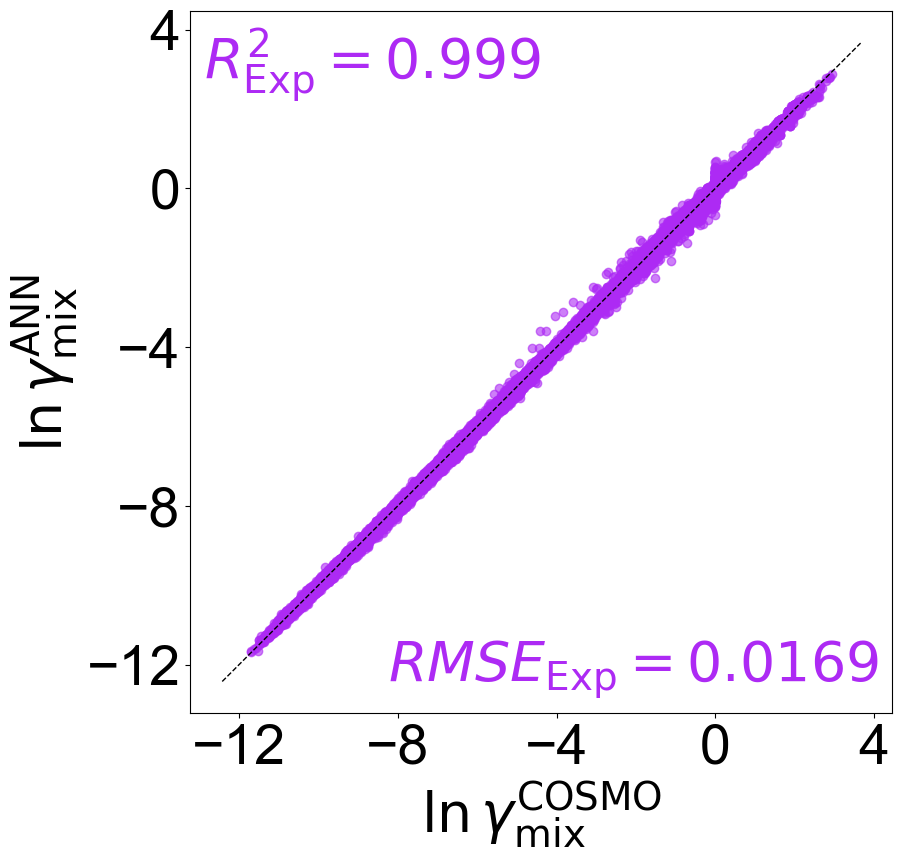

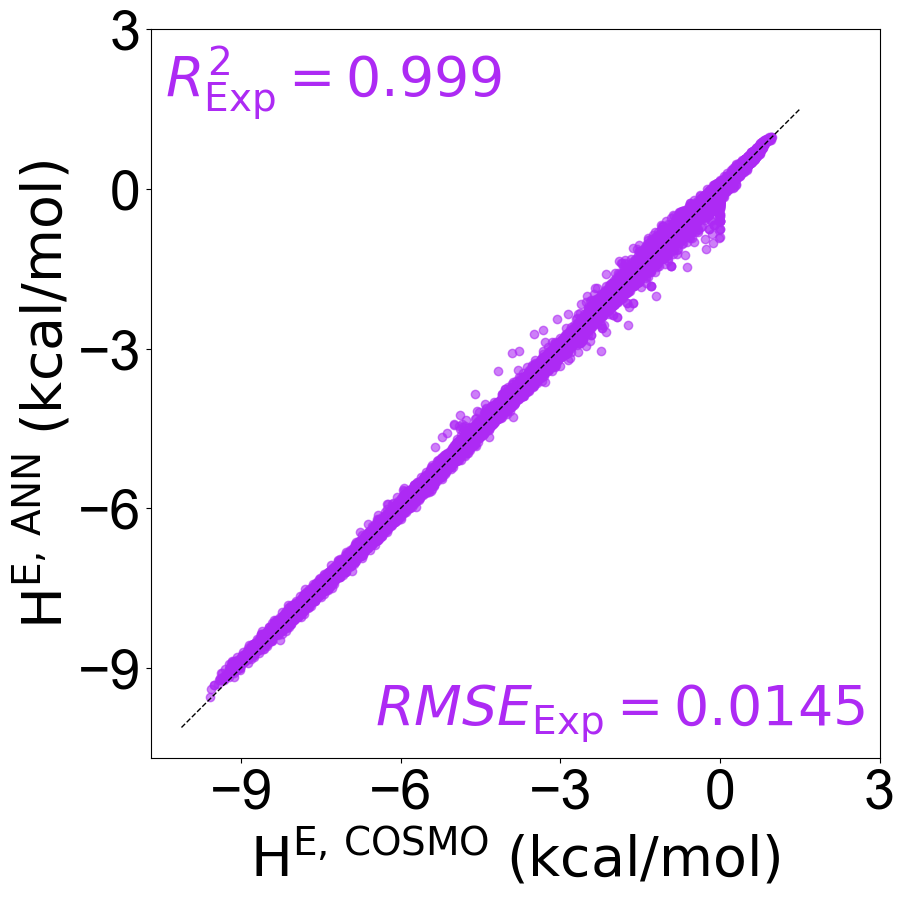

In [16]:
import numpy as np
import torch
import joblib
import os
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error


# --- Paths ---
base = r"H:\Nahid\BinaryILsgammadata"
#test_path = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_298_miscibility.csv"
test_path = r"H:\Nahid\BinaryILsgammadata\Train.csv"
train='#1F51FF'
val='#191970'
test='#5D3FD3'
exp='#AD2AF4'

Color=exp

output_dir = os.path.join(base, "ANN_weights_mix")

# --- Load scalers ---
x_scaler = joblib.load(os.path.join(output_dir, "x_scaler.gz"))
y_scaler = joblib.load(os.path.join(output_dir, "y_scaler.gz"))

# --- Reproducibility ---
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass
def prepare_data(df: pl.DataFrame):
    # Feature slices must match training & inference
    mole_frac_df = df[:, 5:6]      # x
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]

    # Build X as numpy float32
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # Targets (convert to numpy first, then compute)
    mole_frac = mole_frac_df.to_numpy().astype(np.float32)
    gama1_ln  = np.log(df[:, 6:7].to_numpy()).astype(np.float32)  # ln(gamma1)
    gama2_ln  = np.log(df[:, 7:8].to_numpy()).astype(np.float32)  # ln(gamma2)
    HE        = df[:, 8:9].to_numpy().astype(np.float32)

    ln_gama_mix = mole_frac * gama1_ln + (1.0 - mole_frac) * gama2_ln
    y = np.concatenate([ln_gama_mix, HE], axis=1).astype(np.float32)

    return X, y

# --- Clean Data ---
def read_and_clean(path: str) -> pl.DataFrame:
    # Explicitly override schema to avoid Polars guessing i64
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }

    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",   # handles weird characters safely
        ignore_errors=False
    )

    cols_to_check = df.columns[6:110]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check]))
    )


# --- Define Model ---
class ANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.net(x)

# --- Load model ---
input_size = 101
hidden_size = 128
output_size = 2

model = ANN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(os.path.join(output_dir, "model_state.pt")))
model.eval()

# --- Inference ---
test_df = read_and_clean(test_path)


# Prepare model inputs
X_test, y_test = prepare_data(test_df)
X_test_s = x_scaler.transform(X_test)

# Predict
with torch.no_grad():
    preds_s = model(torch.tensor(X_test_s, dtype=torch.float32)).numpy()

preds_u = y_scaler.inverse_transform(preds_s)


# plotting


ln_gamma_mix_pred = preds_u[:, 0]
HE_pred           = preds_u[:, 1]

ln_gamma_mix_COSMO = y_test[:, 0]
HE_COSMO           = y_test[:, 1]

# Metrics
r2_activity  = r2_score(ln_gamma_mix_COSMO, ln_gamma_mix_pred)
rmse_activity = np.sqrt(mean_squared_error(ln_gamma_mix_COSMO, ln_gamma_mix_pred))

r2_enthalpy  = r2_score(HE_COSMO, HE_pred)
rmse_enthalpy = np.sqrt(mean_squared_error(HE_COSMO, HE_pred))

# Global style (fix the font name!)
plt.rcParams.update({'font.family': 'Arial', 'font.size': 40})

# ---------- Plot 1: ln γ_mix ----------
fig, ax = plt.subplots(figsize=(10, 10))


ax.scatter(ln_gamma_mix_COSMO, ln_gamma_mix_pred, alpha=0.6, marker='o',color=Color)
#ax.scatter(ln_gamma_mix_COSMO, ln_gamma_mix_pred, alpha=0.6, marker='o',color=test)
#ax.scatter(ln_gamma_mix_COSMO, ln_gamma_mix_pred, alpha=0.6, marker='o',color=val)

# 1:1 line
lo = float(min(ln_gamma_mix_COSMO.min(), ln_gamma_mix_pred.min()))
hi = float(max(ln_gamma_mix_COSMO.max(), ln_gamma_mix_pred.max()))
pad = 0.05 * (hi - lo if hi > lo else 1.0)
a, b = lo - pad, hi + pad
ax.plot([a, b], [a, b], 'k--', lw=1)



ax.text(0.02, 0.98, fr"$R_{{\mathrm{{Exp}}}}^{{2}}= {r2_activity:.3f}$", transform=ax.transAxes, va='top',ha='left',color=Color)
ax.text(0.98, 0.02, fr"$RMSE_{{\mathrm{{Exp}}}} = {rmse_activity:.4f}$", transform=ax.transAxes, va='bottom', ha='right',color=Color)

ax.set_xlabel(r"$\ln\gamma_{\mathrm{mix}}^{\mathrm{COSMO}}$")
ax.set_ylabel(r"$\ln\gamma_{\mathrm{mix}}^{\mathrm{ANN}}$")
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([-12,-8,-4,0,4])
ax.set_yticks([-12,-8,-4,0,4])
plt.tight_layout()
plt.show()

# ---------- Plot 2: ΔH ----------
fig, ax = plt.subplots(figsize=(10, 10))
#ax.scatter(HE_COSMO, HE_pred, alpha=0.6, marker='o',color='#1F51FF')
ax.scatter(HE_COSMO, HE_pred, alpha=0.6, marker='o',color=Color)
#ax.scatter(HE_COSMO, HE_pred, alpha=0.6, marker='o',color='#5D3FD3')

# 1:1 line
lo = float(min(HE_COSMO.min(), HE_pred.min()))
hi = float(max(HE_COSMO.max(), HE_pred.max()))
pad = 0.05 * (hi - lo if hi > lo else 1.0)
a, b = lo - pad, hi + pad
ax.plot([a, b], [a, b], 'k--', lw=1)



# Text: R² top-left, RMSE bottom-right (no box)
ax.text(0.02, 0.98, fr"$R_{{\mathrm{{Exp}}}}^{{2}} = {r2_enthalpy:.3f}$", transform=ax.transAxes, va='top', ha='left',color=Color)
ax.text(0.98, 0.02, fr"$RMSE_{{\mathrm{{Exp}}}} = {rmse_enthalpy:.4f}$", transform=ax.transAxes, va='bottom', ha='right',color=Color)


ax.set_xlabel(r"$\mathrm{H}^{\mathrm{E},\,\mathrm{COSMO}}\;(\mathrm{kcal/mol})$")
ax.set_ylabel(r"$\mathrm {H}^{\mathrm{E},\,\mathrm{ANN}}\;(\mathrm{kcal/mol})$")

# ax.set_xlabel(r"$\Delta H_{\mathrm{COSMO}} (kcal/mol)$")
# ax.set_ylabel(r"$\Delta H_{\mathrm{ANN}}(kcal/mol)$")
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([-9,-6,-3,0,3])
ax.set_yticks([-9,-6,-3,0,3])
plt.tight_layout()
plt.show()


[lnγ_mix]  R^2_Test=0.9995  R^2_Exp=0.9723  RMSE_Test=0.017183  RMSE_Exp=0.052007
[ΔH]       R^2_Test=0.9994  R^2_Exp=0.9038  RMSE_Test=0.014677  RMSE_Exp=0.051574


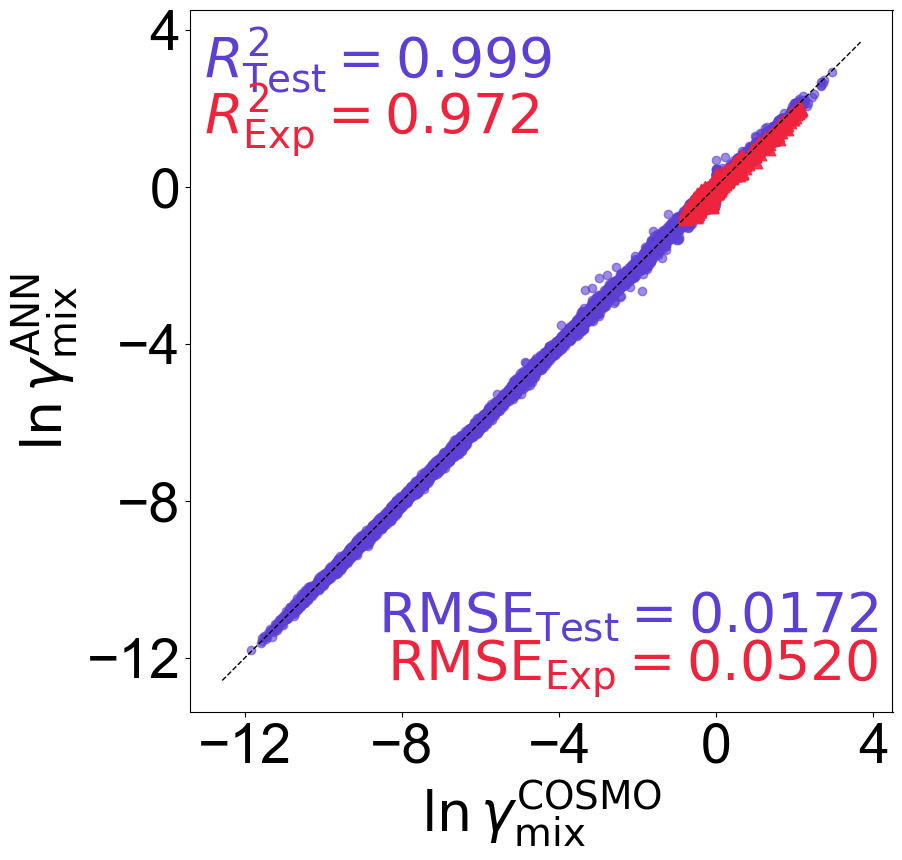

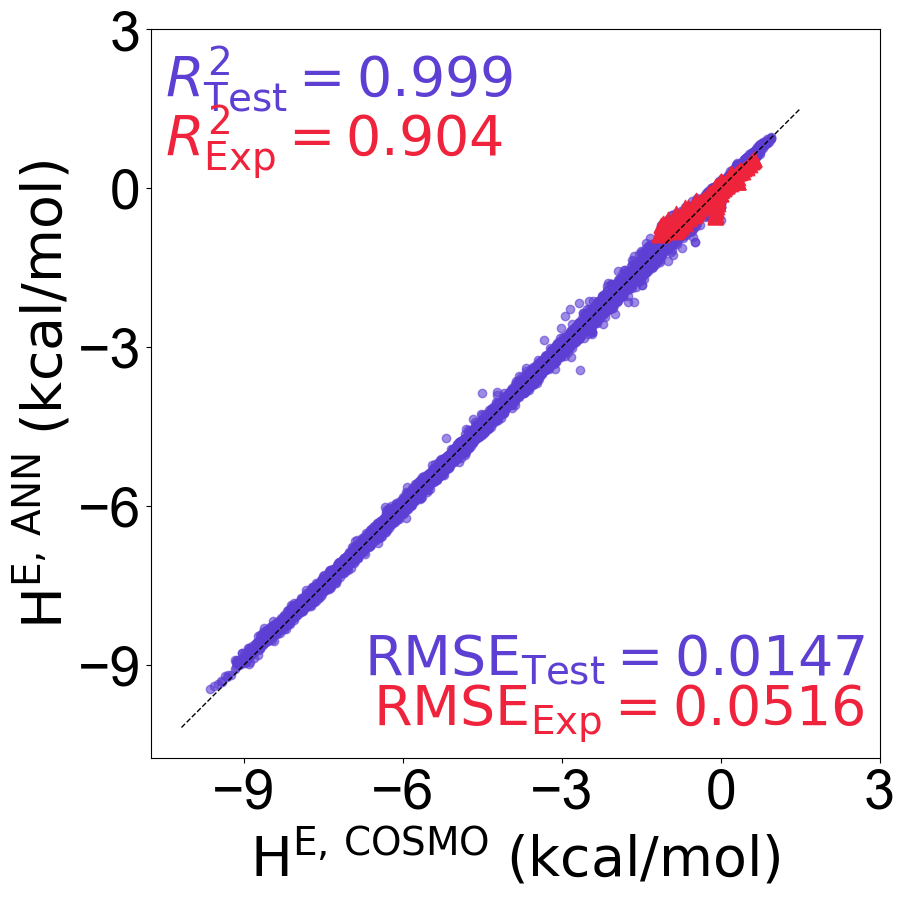

In [27]:
import numpy as np
import torch
import joblib
import os
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

# =========================
# Paths (edit if needed)
# =========================
base = r"H:\Nahid\BinaryILsgammadata"
test_path = r"H:\Nahid\BinaryILsgammadata\test.csv"  # your existing test set
exp_path  = r"H:\Nahid\BinaryILsgammadata\Clean_expdata.csv" # second dataset
output_dir = os.path.join(base, "ANN_weights_mix")

test='#5D3FD3'
# exp='#AD2AF4'
exp='#ef233c'
# =========================
# Load scalers & model
# =========================
x_scaler = joblib.load(os.path.join(output_dir, "x_scaler.gz"))
y_scaler = joblib.load(os.path.join(output_dir, "y_scaler.gz"))

torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# =========================
# Data prep utilities
# =========================
def prepare_data(df: pl.DataFrame):
    # Feature slices must match training & inference
    mole_frac_df = df[:, 5:6]      # x
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]

    # Build X as numpy float32
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # Targets (convert to numpy first, then compute)
    mole_frac = mole_frac_df.to_numpy().astype(np.float32)
    gama1_ln  = np.log(df[:, 6:7].to_numpy()).astype(np.float32)  # ln(gamma1)
    gama2_ln  = np.log(df[:, 7:8].to_numpy()).astype(np.float32)  # ln(gamma2)
    HE        = df[:, 8:9].to_numpy().astype(np.float32)

    ln_gama_mix = mole_frac * gama1_ln + (1.0 - mole_frac) * gama2_ln
    y = np.concatenate([ln_gama_mix, HE], axis=1).astype(np.float32)

    return X, y

def read_and_clean(path: str) -> pl.DataFrame:
    # Explicitly override schema to avoid Polars guessing i64
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }

    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",
        ignore_errors=False
    )

    cols_to_check = df.columns[6:110]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check]))
    )

# =========================
# Model definition & load
# =========================
class ANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.net(x)

input_size = 101
hidden_size = 128
output_size = 2

model = ANN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(os.path.join(output_dir, "model_state.pt"), map_location="cpu"))
model.eval()

# =========================
# Evaluation helper
# =========================
def evaluate_dataset(path: str):
    df = read_and_clean(path)
    X, y = prepare_data(df)
    Xs = x_scaler.transform(X)
    with torch.no_grad():
        yhat_s = model(torch.tensor(Xs, dtype=torch.float32)).numpy()
    yhat_u = y_scaler.inverse_transform(yhat_s)

    ln_ref  = y[:, 0]
    he_ref  = y[:, 1]
    ln_pred = yhat_u[:, 0]
    he_pred = yhat_u[:, 1]

    r2_ln   = r2_score(ln_ref, ln_pred)
    rmse_ln = np.sqrt(mean_squared_error(ln_ref, ln_pred))
    r2_he   = r2_score(he_ref, he_pred)
    rmse_he = np.sqrt(mean_squared_error(he_ref, he_pred))

    return {
        "ln_ref": ln_ref, "ln_pred": ln_pred,
        "he_ref": he_ref, "he_pred": he_pred,
        "r2_ln": r2_ln, "rmse_ln": rmse_ln,
        "r2_he": r2_he, "rmse_he": rmse_he,
        "n": len(df)
    }

# =========================
# Run evaluation on both sets
# =========================
test_results = evaluate_dataset(test_path)
exp_results  = evaluate_dataset(exp_path)

print(f"[lnγ_mix]  R^2_Test={test_results['r2_ln']:.4f}  R^2_Exp={exp_results['r2_ln']:.4f}  "
      f"RMSE_Test={test_results['rmse_ln']:.6f}  RMSE_Exp={exp_results['rmse_ln']:.6f}")
print(f"[ΔH]       R^2_Test={test_results['r2_he']:.4f}  R^2_Exp={exp_results['r2_he']:.4f}  "
      f"RMSE_Test={test_results['rmse_he']:.6f}  RMSE_Exp={exp_results['rmse_he']:.6f}")

# =========================
# Small helper to avoid text overlap
# =========================
def place_metrics(ax, r2_t, r2_e, rmse_t, rmse_e, c_t, c_e, dy=0.08):
    # ---- Top-left (R^2): Test first, Exp below ----
    ax.text(0.02, 0.98,      fr"$R_{{\mathrm{{Test}}}}^2={r2_t:.3f}$",
            transform=ax.transAxes, ha='left', va='top', color=c_t)
    ax.text(0.02, 0.98 - dy, fr"$R_{{\mathrm{{Exp}}}}^2={r2_e:.3f}$",
            transform=ax.transAxes, ha='left', va='top', color=c_e)

    # ---- Bottom-right (RMSE): Test first, Exp below ----
    ax.text(0.98, 0.02 + dy, fr"$\mathrm{{RMSE}}_{{\mathrm{{Test}}}}={rmse_t:.4f}$",
            transform=ax.transAxes, ha='right', va='bottom', color=c_t)
    ax.text(0.98, 0.02,      fr"$\mathrm{{RMSE}}_{{\mathrm{{Exp}}}}={rmse_e:.4f}$",
            transform=ax.transAxes, ha='right', va='bottom', color=c_e)

# =========================
# Plotting (overlaid, no legend; R^2 top-left, RMSE bottom-right)
# =========================
plt.rcParams.update({'font.family': 'Arial', 'font.size': 40})

# ---------- Plot 1: ln γ_mix (Test + Exp) ----------
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(test_results["ln_ref"], test_results["ln_pred"], alpha=0.6, marker='o',
           color=test)
ax.scatter(exp_results["ln_ref"],  exp_results["ln_pred"],  alpha=0.9, marker='^',
           s=110, linewidth=0.9, color=exp)

# 1:1 line covering BOTH datasets
lo = float(min(test_results["ln_ref"].min(), test_results["ln_pred"].min(),
               exp_results["ln_ref"].min(),  exp_results["ln_pred"].min()))
hi = float(max(test_results["ln_ref"].max(), test_results["ln_pred"].max(),
               exp_results["ln_ref"].max(),  exp_results["ln_pred"].max()))
pad = 0.05 * (hi - lo if hi > lo else 1.0)
a, b = lo - pad, hi + pad
ax.plot([a, b], [a, b], 'k--', lw=1)

# Place metrics (avoids overlap)
place_metrics(ax,
              test_results['r2_ln'],  exp_results['r2_ln'],
              test_results['rmse_ln'],exp_results['rmse_ln'],
              test, exp)

ax.set_xlabel(r"$\ln\gamma_{\mathrm{mix}}^{\mathrm{COSMO}}$")
ax.set_ylabel(r"$\ln\gamma_{\mathrm{mix}}^{\mathrm{ANN}}$")
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([-12,-8,-4,0,4])
ax.set_yticks([-12,-8,-4,0,4])
plt.tight_layout()
# plt.savefig(os.path.join(base, "parity_ln_gamma_mix_Test_Exp_nolegend.png"), dpi=300)
plt.show()

# ---------- Plot 2: ΔH (Test + Exp) ----------
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(test_results["he_ref"], test_results["he_pred"], alpha=0.6, marker='o',
           color=test)
ax.scatter(exp_results["he_ref"],  exp_results["he_pred"],  alpha=0.9, marker='^',
           s=110, linewidth=0.9, color=exp)

# 1:1 line covering BOTH datasets
lo = float(min(test_results["he_ref"].min(), test_results["he_pred"].min(),
               exp_results["he_ref"].min(),  exp_results["he_pred"].min()))
hi = float(max(test_results["he_ref"].max(), test_results["he_pred"].max(),
               exp_results["he_ref"].max(),  exp_results["he_pred"].max()))
pad = 0.05 * (hi - lo if hi > lo else 1.0)
a, b = lo - pad, hi + pad
ax.plot([a, b], [a, b], 'k--', lw=1)

# Place metrics (avoids overlap)
place_metrics(ax,
              test_results['r2_he'],  exp_results['r2_he'],
              test_results['rmse_he'],exp_results['rmse_he'],
              test, exp)

ax.set_xlabel(r"$\mathrm{H}^{\mathrm{E},\,\mathrm{COSMO}}\;(\mathrm{kcal/mol})$")
ax.set_ylabel(r"$\mathrm{H}^{\mathrm{E},\,\mathrm{ANN}}\;(\mathrm{kcal/mol})$")
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([-9,-6,-3,0,3])
ax.set_yticks([-9,-6,-3,0,3])
plt.tight_layout()
# plt.savefig(os.path.join(base, "parity_dH_Test_Exp_nolegend.png"), dpi=300)
plt.show()


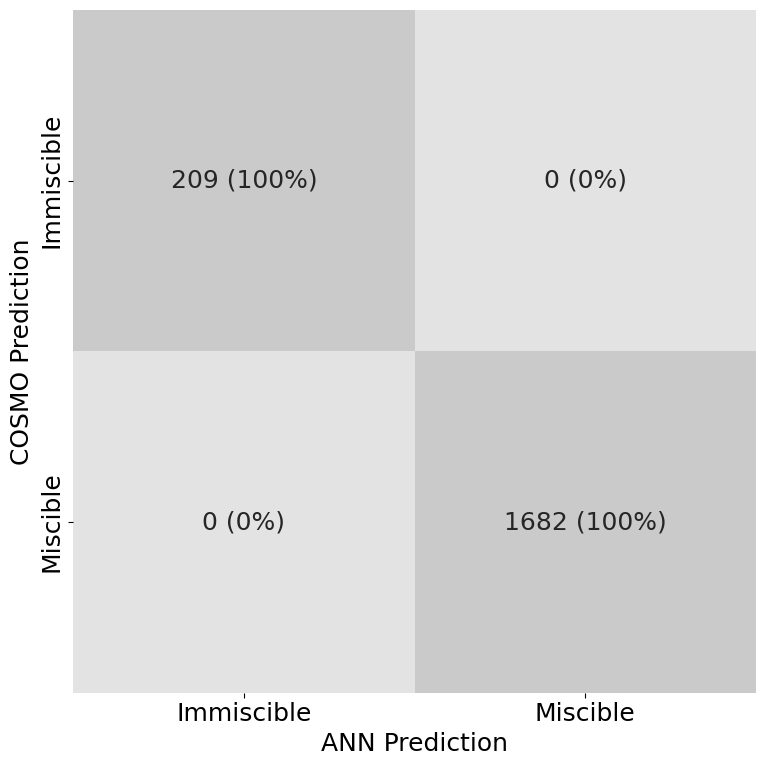


Classification Report:
              precision    recall  f1-score   support

  Immiscible       1.00      1.00      1.00       209
    Miscible       1.00      1.00      1.00      1682

    accuracy                           1.00      1891
   macro avg       1.00      1.00      1.00      1891
weighted avg       1.00      1.00      1.00      1891

✅ Saved predictions to predicted_miscibility.csv


In [18]:
import numpy as np
import torch
import joblib
import os
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# --- Paths ---
base = r"H:\Nahid\BinaryILsgammadata"
test_path = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_298_miscibility.csv"
output_dir = os.path.join(base, "ANN_weights_mix")

# --- Load scalers ---
x_scaler = joblib.load(os.path.join(output_dir, "x_scaler.gz"))
y_scaler = joblib.load(os.path.join(output_dir, "y_scaler.gz"))

# --- Reproducibility ---
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# --- Prepare Data ---
def prepare_data(df: pl.DataFrame):
    # Feature slices must match training & inference
    mole_frac_df = df[:, 5:6]      # x
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]

    # Build X as numpy float32
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # Targets (convert to numpy first, then compute)
    mole_frac = mole_frac_df.to_numpy().astype(np.float32)
    gama1_ln  = np.log(df[:, 6:7].to_numpy()).astype(np.float32)  # ln(gamma1)
    gama2_ln  = np.log(df[:, 7:8].to_numpy()).astype(np.float32)  # ln(gamma2)
    HE        = df[:, 8:9].to_numpy().astype(np.float32)

    ln_gama_mix = mole_frac * gama1_ln + (1.0 - mole_frac) * gama2_ln
    y = np.concatenate([ln_gama_mix, HE], axis=1).astype(np.float32)

    return X, y

# --- Clean Data ---
def read_and_clean(path: str) -> pl.DataFrame:
    # Explicitly override schema to avoid Polars guessing i64
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }

    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",   # handles weird characters safely
        ignore_errors=False
    )

    cols_to_check = df.columns[6:110]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check]))
    )


# --- Define Model ---
class ANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.net(x)

# --- Load model ---
input_size = 101
hidden_size = 128
output_size = 2

model = ANN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(os.path.join(output_dir, "model_state.pt")))
model.eval()

# --- Inference ---
test_df = read_and_clean(test_path)

# Extract true labels from column 5
true_col = test_df[:, 110].cast(str).str.strip_chars().str.to_lowercase()
true_labels = np.where(true_col == "miscible", 1, 0)

# Prepare model inputs
X_test, y_test = prepare_data(test_df)
X_test_s = x_scaler.transform(X_test)

# Predict
with torch.no_grad():
    preds_s = model(torch.tensor(X_test_s, dtype=torch.float32)).numpy()

preds_u = y_scaler.inverse_transform(preds_s)

# --- Classification based on predicted gamma_mix ---
ln_gamma_mix_pred = preds_u[:, 0]
gamma_mix_pred = np.exp(ln_gamma_mix_pred)
predicted_labels = (gamma_mix_pred < 1.15).astype(int)  # 1 = miscible

# --- Confusion matrix ---
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
row_sums = cm.sum(axis=1, keepdims=True)
cm_pct = np.divide(cm * 100.0, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

labels_annot = np.array([
    [f"{cm[0,0]} ({cm_pct[0,0]:.0f}%)", f"{cm[0,1]} ({cm_pct[0,1]:.0f}%)"],
    [f"{cm[1,0]} ({cm_pct[1,0]:.0f}%)", f"{cm[1,1]} ({cm_pct[1,1]:.0f}%)"]
])
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_pct,
    annot=labels_annot,
    fmt='',
    cmap = LinearSegmentedColormap.from_list("mycmap", ["#e3e3e3", "#cacaca"]),
    vmin=0,
    vmax=100,
    square=True,
    xticklabels=["Immiscible", "Miscible"],
    yticklabels=["Immiscible", "Miscible"],
    cbar=False,
    cbar_kws={"label": "Percentage (%)"}
)
ax.set_xlabel("ANN Prediction", fontsize=18)
ax.set_ylabel("COSMO Prediction", fontsize=18)
plt.tight_layout()
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Immiscible", "Miscible"]))

# --- Optional: Save to CSV ---
df_out = pd.DataFrame({
    "true_label": true_labels,
    "predicted_label": predicted_labels,
    "gamma_mix": gamma_mix_pred
})
df_out.to_csv(os.path.join(output_dir, "predicted_miscibility.csv"), index=False)
print("✅ Saved predictions to predicted_miscibility.csv")



In [7]:

import os
import polars as pl

path = r"H:\Nahid\BinaryILsgammadata\Clean_expdata.csv" # <- change
tmp_path = path + ".tmp"

q = (
    pl.scan_csv(path)
      .with_columns(
          pl.col("x1").cast(pl.Float64),
          pl.col("gam1").cast(pl.Float64),
          pl.col("gam2").cast(pl.Float64),
      )
      .with_columns(
          pl.when(
              (pl.col("x1") * pl.col("gam1").log()
               + (1 - pl.col("x1")) * pl.col("gam2").log()
              ).exp() < 1.20
          )
          .then(pl.lit("Miscible"))
          .otherwise(pl.lit("Immiscible"))
          .alias("Miscibility")
      )
)

q.sink_csv(tmp_path)         # write to temp
os.replace(tmp_path, path)   # atomic replace
print("Updated in place with 'Miscibility':", path)




ComputeError: could not parse `1.2058187` as dtype `i64` at column 'sigma2_41' (column number 102)

The current offset in the file is 713 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `schema_overrides` argument
- setting `ignore_errors` to `True`,
- adding `1.2058187` to the `null_values` list.

Original error: ```remaining bytes non-empty```

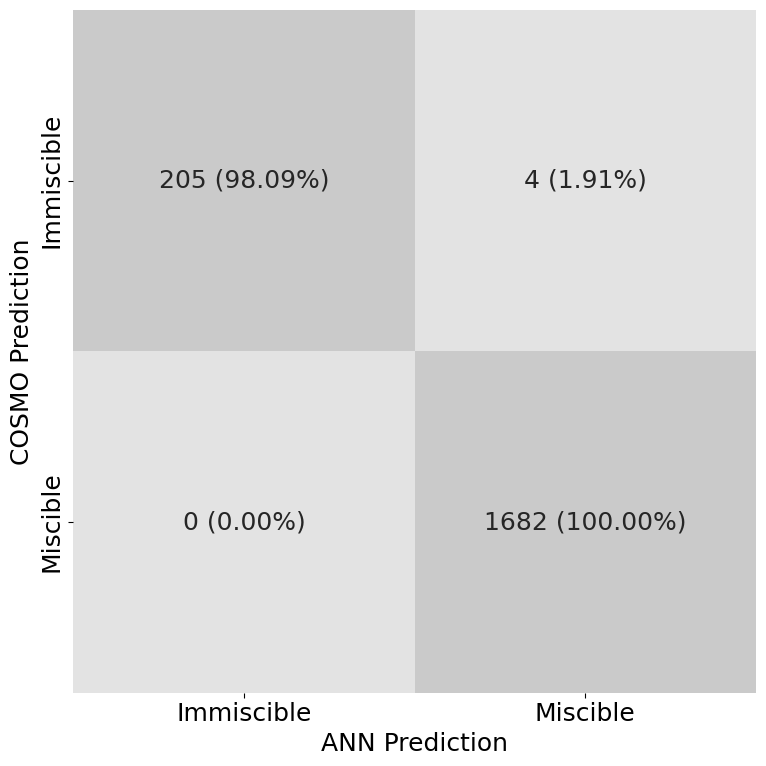


Classification Report:
              precision    recall  f1-score   support

  Immiscible       1.00      0.98      0.99       209
    Miscible       1.00      1.00      1.00      1682

    accuracy                           1.00      1891
   macro avg       1.00      0.99      0.99      1891
weighted avg       1.00      1.00      1.00      1891

✅ Saved predictions to predicted_miscibility.csv


In [16]:
import numpy as np
import torch
import joblib
import os
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# --- Paths ---
base = r"H:\Nahid\BinaryILsgammadata"
test_path = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_298_miscibility.csv"
output_dir = os.path.join(base, "ANN_weights_mix")

# --- Load scalers ---
x_scaler = joblib.load(os.path.join(output_dir, "x_scaler.gz"))
y_scaler = joblib.load(os.path.join(output_dir, "y_scaler.gz"))

# --- Reproducibility ---
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# --- Prepare Data ---
def prepare_data(df: pl.DataFrame):
    # Feature slices must match training & inference
    mole_frac_df = df[:, 5:6]      # x
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]

    # Build X as numpy float32
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # Targets (convert to numpy first, then compute)
    mole_frac = mole_frac_df.to_numpy().astype(np.float32)
    gama1_ln  = np.log(df[:, 6:7].to_numpy()).astype(np.float32)  # ln(gamma1)
    gama2_ln  = np.log(df[:, 7:8].to_numpy()).astype(np.float32)  # ln(gamma2)
    HE        = df[:, 8:9].to_numpy().astype(np.float32)

    ln_gama_mix = mole_frac * gama1_ln + (1.0 - mole_frac) * gama2_ln
    y = np.concatenate([ln_gama_mix, HE], axis=1).astype(np.float32)

    return X, y

# --- Clean Data ---
def read_and_clean(path: str) -> pl.DataFrame:
    # Explicitly override schema to avoid Polars guessing i64
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }

    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",   # handles weird characters safely
        ignore_errors=False
    )

    cols_to_check = df.columns[6:110]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check]))
    )


# --- Define Model ---
class ANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.net(x)

# --- Load model ---
input_size = 101
hidden_size = 128
output_size = 2

model = ANN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(os.path.join(output_dir, "model_state.pt")))
model.eval()

# --- Inference ---
test_df = read_and_clean(test_path)

# Extract true labels from column 5
true_col = test_df[:, 110].cast(str).str.strip_chars().str.to_lowercase()
true_labels = np.where(true_col == "miscible", 1, 0)

# Prepare model inputs
X_test, y_test = prepare_data(test_df)
X_test_s = x_scaler.transform(X_test)

# Predict
with torch.no_grad():
    preds_s = model(torch.tensor(X_test_s, dtype=torch.float32)).numpy()

preds_u = y_scaler.inverse_transform(preds_s)

# --- Classification based on predicted gamma_mix ---
ln_gamma_mix_pred = preds_u[:, 0]
gamma_mix_pred = np.exp(ln_gamma_mix_pred)
predicted_labels = (gamma_mix_pred <= 1.20).astype(int)  # 1 = miscible

# --- Confusion matrix ---
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
row_sums = cm.sum(axis=1, keepdims=True)
cm_pct = np.divide(cm * 100.0, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

labels_annot = np.array([
    [f"{cm[0,0]} ({cm_pct[0,0]:.2f}%)", f"{cm[0,1]} ({cm_pct[0,1]:.2f}%)"],
    [f"{cm[1,0]} ({cm_pct[1,0]:.2f}%)", f"{cm[1,1]} ({cm_pct[1,1]:.2f}%)"]
])
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_pct,
    annot=labels_annot,
    fmt='',
    cmap = LinearSegmentedColormap.from_list("mycmap", ["#e3e3e3", "#cacaca"]),
    vmin=0,
    vmax=100,
    square=True,
    xticklabels=["Immiscible", "Miscible"],
    yticklabels=["Immiscible", "Miscible"],
    cbar=False,
    cbar_kws={"label": "Percentage (%)"}
)
ax.set_xlabel("ANN Prediction", fontsize=18)
ax.set_ylabel("COSMO Prediction", fontsize=18)
plt.tight_layout()
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Immiscible", "Miscible"]))

# --- Optional: Save to CSV ---
df_out = pd.DataFrame({
    "true_label": true_labels,
    "predicted_label": predicted_labels,
    "gamma_mix": gamma_mix_pred
})
df_out.to_csv(os.path.join(output_dir, "predicted_miscibility.csv"), index=False)
print("✅ Saved predictions to predicted_miscibility.csv")

In [9]:
import os, json
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix
)
import joblib

# =========================
# Paths
# =========================
base = r"H:\Nahid\BinaryILsgammadata"
train_path = os.path.join(base, "train.csv")
val_path   = os.path.join(base, "val.csv")
test_path  = os.path.join(base, "test.csv")

output_dir = os.path.join(base, "ANN_weights_binary")
os.makedirs(output_dir, exist_ok=True)

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# =========================
# Data reading / cleaning
# =========================
def read_and_clean(path: str) -> pl.DataFrame:
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }
    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",
        ignore_errors=False
    )
    # Clean numeric columns from col 6 onward; keep UTF8 columns untouched (label)
    cols_to_check = df.columns[6:]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check if df.schema[c] != pl.Utf8]))
    )

# =========================
# Feature/label slicing
# X: [x (col 5), sigma1 10:60, sigma2 60:110]
# y: STRICTLY column 110 text: "miscible"/"immiscible"
# =========================
def prepare_data_cls(df: pl.DataFrame):
    # --- features ---
    mole_frac_df = df[:, 5:6]
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # --- label from column 110, text only ---
    if len(df.columns) < 111:
        raise ValueError(
            f"Expected a label at column index 110, but dataframe has only {len(df.columns)} columns."
        )
    label_col_name = df.columns[110]
    y_series = df.select(pl.col(label_col_name).cast(pl.Utf8)).to_series()
    vals = [(v or "").strip().lower() for v in y_series.to_list()]

    bad = {v for v in vals if v not in ("miscible", "immiscible")}
    if bad:
        preview = ", ".join(list(bad)[:10])
        raise ValueError(
            f"Column 110 must contain only 'miscible' or 'immiscible'. Unexpected values: {preview}"
        )

    y = np.array([1 if v == "miscible" else 0 for v in vals], dtype=np.int64)

    if not hasattr(prepare_data_cls, "_printed"):
        print(f"Using label column 110 (name: {label_col_name!r}) with text-only mapping.")
        prepare_data_cls._printed = True

    return X, y

# =========================
# Load data
# =========================
train_df = read_and_clean(train_path)
val_df   = read_and_clean(val_path)
test_df  = read_and_clean(test_path)

X_train, y_train = prepare_data_cls(train_df)
X_val,   y_val   = prepare_data_cls(val_df)
X_test,  y_test  = prepare_data_cls(test_df)

# =========================
# Scale X only (fit on train)
# =========================
x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

# =========================
# Datasets / Loaders
# =========================
class MixClsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # BCEWithLogits expects float targets
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(MixClsDataset(X_train_s, y_train), batch_size=1024, shuffle=True)
val_loader   = DataLoader(MixClsDataset(X_val_s,   y_val),   batch_size=1024)
test_loader  = DataLoader(MixClsDataset(X_test_s,  y_test),  batch_size=1024)

input_size  = X_train_s.shape[1]  # 101 with current slices
hidden_size = 128

# =========================
# Model (same body, 1-logit head)
# =========================
class ANN_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),  # one logit
        )
    def forward(self, x): return self.net(x)

model = ANN_Classifier(input_size, hidden_size)

# =========================
# Loss (class imbalance via pos_weight)
# =========================
pos_count = max(1, int((y_train == 1).sum()))
neg_count = max(1, int((y_train == 0).sum()))
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32)  # >1 if positives are rarer

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# =========================
# Train
# =========================
n_epochs = 40
for epoch in range(n_epochs):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb).squeeze(1)              # (B,)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb).squeeze(1)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1:02d}/{n_epochs}  Train {running/len(train_loader):.6f}  Val {val_loss/len(val_loader):.6f}")

# =========================
# Evaluation
# =========================
def eval_cls(loader, name, threshold=0.5):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            lg = model(xb).squeeze(1)
            all_logits.append(lg.numpy())
            all_y.append(yb.numpy())
    logits = np.concatenate(all_logits)
    y_true = np.concatenate(all_y).astype(int)
    probs = 1/(1+np.exp(-logits))
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float("nan")
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n[{name}]  ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc, "cm": cm.tolist()}

_ = eval_cls(train_loader, "Train")
_ = eval_cls(val_loader,   "Val")
_ = eval_cls(test_loader,  "Test")

# =========================
# Save artifacts
# =========================
torch.save(model.state_dict(), os.path.join(output_dir, "model_state_cls.pt"))
joblib.dump(x_scaler, os.path.join(output_dir, "x_scaler_cls.gz"))

meta = {
    "task": "binary_classification",
    "label_mapping": {"immiscible": 0, "miscible": 1},
    "x_cols": {"mole_frac": [5,6], "IL1_sigma": [10,60], "IL2_sigma": [60,110]},
    "y_col": 110,
    "input_size": int(input_size),
    "hidden_size": int(hidden_size),
    "output_size": 1,
    "decision_threshold": 0.5,
    "note": "Half-open slices [start,stop). Label at column 110 must be 'miscible' or 'immiscible' (text only).",
    "class_balance": {"train_pos": int((y_train==1).sum()), "train_neg": int((y_train==0).sum())}
}
with open(os.path.join(output_dir, "meta_cls.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("\n✅ Saved classification artifacts to:", output_dir)
print("   - model_state_cls.pt")
print("   - x_scaler_cls.gz")
print("   - meta_cls.json")


Using label column 110 (name: 'Miscibility') with text-only mapping.
Epoch 01/40  Train 0.011902  Val 0.006687
Epoch 02/40  Train 0.006274  Val 0.006124
Epoch 03/40  Train 0.005419  Val 0.004805
Epoch 04/40  Train 0.004783  Val 0.005108
Epoch 05/40  Train 0.004456  Val 0.004181
Epoch 06/40  Train 0.004191  Val 0.004292
Epoch 07/40  Train 0.003945  Val 0.004559
Epoch 08/40  Train 0.003757  Val 0.004000
Epoch 09/40  Train 0.003636  Val 0.003478
Epoch 10/40  Train 0.003481  Val 0.003564
Epoch 11/40  Train 0.003388  Val 0.004011
Epoch 12/40  Train 0.003271  Val 0.003334
Epoch 13/40  Train 0.003157  Val 0.003079
Epoch 14/40  Train 0.003058  Val 0.003089
Epoch 15/40  Train 0.002999  Val 0.002907
Epoch 16/40  Train 0.002931  Val 0.003287
Epoch 17/40  Train 0.002829  Val 0.003272
Epoch 18/40  Train 0.002771  Val 0.003216
Epoch 19/40  Train 0.002723  Val 0.003419
Epoch 20/40  Train 0.002701  Val 0.002858
Epoch 21/40  Train 0.002614  Val 0.003286
Epoch 22/40  Train 0.002535  Val 0.003133
Epoch 2

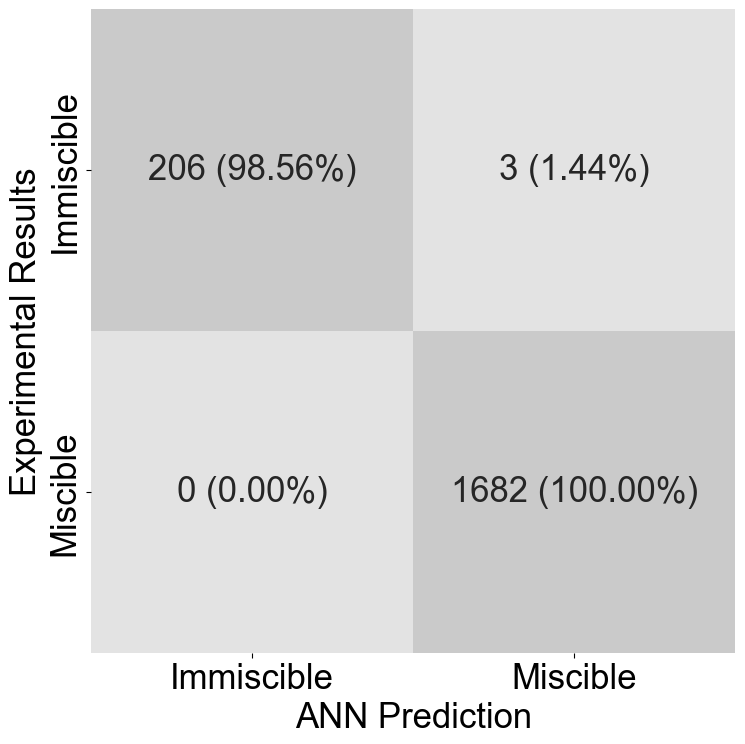


Classification Report (threshold = 0.50):
              precision    recall  f1-score   support

  Immiscible       1.00      0.99      0.99       209
    Miscible       1.00      1.00      1.00      1682

    accuracy                           1.00      1891
   macro avg       1.00      0.99      1.00      1891
weighted avg       1.00      1.00      1.00      1891

✅ Saved predictions to: H:\Nahid\BinaryILsgammadata\ANN_weights_binary\test_predictions_cls.csv


In [22]:
import os, json
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap

# ===== Paths =====
base = r"H:\Nahid\BinaryILsgammadata"
test_path = r"H:\Nahid\BinaryILsgammadata\EXPData\EXP_298_miscibility.csv"
output_dir = os.path.join(base, "ANN_weights_binary")

# Filenames saved by the classifier script
model_path   = os.path.join(output_dir, "model_state_cls.pt")
scaler_path  = os.path.join(output_dir, "x_scaler_cls.gz")
meta_path    = os.path.join(output_dir, "meta_cls.json")  # optional

# ===== Reproducibility =====
torch.manual_seed(0)
np.random.seed(0)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# ===== Load scaler (X only; classification has no y_scaler) =====
x_scaler = joblib.load(scaler_path)

# ===== Data reading / cleaning (same as training) =====
def read_and_clean(path: str) -> pl.DataFrame:
    float_cols = {
        **{f"sigma1_{i}": pl.Float64 for i in range(50)},
        **{f"sigma2_{i}": pl.Float64 for i in range(50)},
    }
    df = pl.read_csv(
        path,
        schema_overrides=float_cols,
        infer_schema_length=10000,
        encoding="utf8-lossy",
        ignore_errors=False
    )
    cols_to_check = df.columns[6:110]
    return (
        df
        .drop_nulls(subset=cols_to_check)
        .filter(pl.all_horizontal([pl.col(c).is_finite() for c in cols_to_check if df.schema[c] != pl.Utf8]))
    )

def prepare_features_and_true(df: pl.DataFrame):
    # Features: x (5:6), sigma1 (10:60), sigma2 (60:110)
    mole_frac_df = df[:, 5:6]
    IL1_sigma_df = df[:, 10:60]
    IL2_sigma_df = df[:, 60:110]
    X = (
        pl.concat([mole_frac_df, IL1_sigma_df, IL2_sigma_df], how="horizontal")
        .to_numpy()
        .astype(np.float32)
    )

    # True labels strictly from column 110 (text only)
    if len(df.columns) < 111:
        raise ValueError(f"Expected label at column index 110, but dataframe has {len(df.columns)} columns.")
    label_col_name = df.columns[110]
    y_series = df.select(pl.col(label_col_name).cast(pl.Utf8)).to_series()
    vals = [(v or "").strip().lower() for v in y_series.to_list()]
    bad = {v for v in vals if v not in ("miscible", "immiscible")}
    if bad:
        show = ", ".join(list(bad)[:10])
        raise ValueError(f"Column 110 must be 'miscible' or 'immiscible' only. Unexpected: {show}")
    y_true = np.array([1 if v == "miscible" else 0 for v in vals], dtype=np.int64)

    return X, y_true

# ===== Define model (must match training) =====
class ANN_Classifier(nn.Module):
    def __init__(self, input_size=101, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),   # single logit
        )
    def forward(self, x): 
        return self.net(x)

# ===== Load model =====
input_size  = 101
hidden_size = 128
model = ANN_Classifier(input_size=input_size, hidden_size=hidden_size)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# ===== Load test =====
test_df = read_and_clean(test_path)
X_test, y_true = prepare_features_and_true(test_df)
X_test_s = x_scaler.transform(X_test)

# ===== Predict (sigmoid → probability of class=1 'miscible') =====
with torch.no_grad():
    logits = model(torch.tensor(X_test_s, dtype=torch.float32)).squeeze(1).numpy()
probs = 1.0 / (1.0 + np.exp(-logits))

# Decision threshold: read from meta if present, else 0.5
thr = 0.5
if os.path.exists(meta_path):
    try:
        with open(meta_path, "r") as f:
            meta = json.load(f)
            if "decision_threshold" in meta:
                thr = float(meta["decision_threshold"])
    except Exception:
        pass

y_pred = (probs >= thr).astype(int)

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
row_sums = cm.sum(axis=1, keepdims=True)
cm_pct = np.divide(cm * 100.0, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

labels_annot = np.array([
    [f"{cm[0,0]} ({cm_pct[0,0]:.2f}%)", f"{cm[0,1]} ({cm_pct[0,1]:.2f}%)"],
    [f"{cm[1,0]} ({cm_pct[1,0]:.2f}%)", f"{cm[1,1]} ({cm_pct[1,1]:.2f}%)"]
])

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_pct,
    annot=labels_annot,
    fmt='',
    cmap=LinearSegmentedColormap.from_list("mycmap", ["#e3e3e3", "#cacaca"]),
    vmin=0,
    vmax=100,
    square=True,
    xticklabels=["Immiscible", "Miscible"],
    yticklabels=["Immiscible", "Miscible"],
    cbar=False
)
ax.set_xlabel("ANN Prediction", fontsize=25)
ax.set_ylabel("Experimental Results", fontsize=25)

plt.tight_layout()
plt.show()

# ===== Classification report =====
print("\nClassification Report (threshold = {:.2f}):".format(thr))
print(classification_report(y_true, y_pred, target_names=["Immiscible", "Miscible"]))

# ===== Optional: Save CSV =====
out_df = pd.DataFrame({
    "true_label": y_true,
    "pred_label": y_pred,
    "prob_miscible": probs
})
out_csv = os.path.join(output_dir, "test_predictions_cls.csv")
out_df.to_csv(out_csv, index=False)
print("✅ Saved predictions to:", out_csv)
